# **Excited States Solvers**

## Introduction

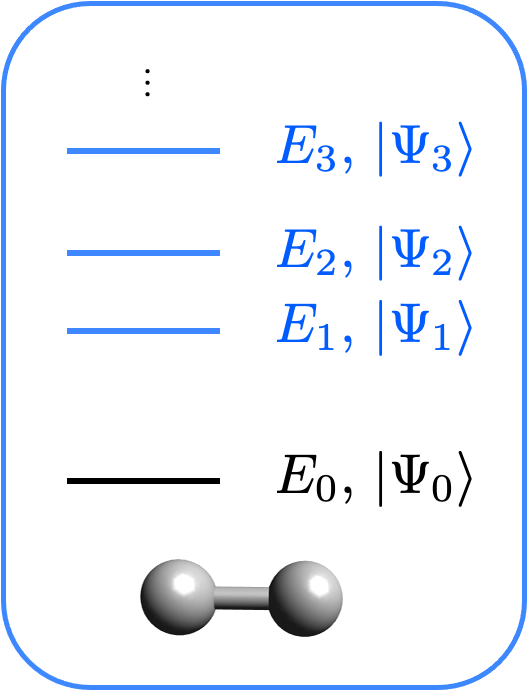

In this tutorial we are going to discuss the excited states calculation interface of Qiskit Nature. The goal is to compute the excited states of a molecular Hamiltonian. This Hamiltonian can be electronic or vibrational. To know more about the preparation of the Hamiltonian, check out the Electronic structure and Vibrational structure tutorials. 

The first step is to define the molecular system. In the following we ask for the electronic part of a hydrogen molecule.

In [1]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(JordanWignerMapper())

## **The Solver**

Then we need to define a solver. The solver is the algorithm through which the ground state is computed. 

Let's first start with a purely classical example: the NumPy eigensolver. This algorithm exactly diagonalizes the Hamiltonian. Although it scales badly, it can be used on small systems to check the results of the quantum algorithms. 
Here, we are only interested to look at eigenstates with a given number of particle. To compute only those states a filter function can be passed to the NumPy eigensolver. A default filter function is already implemented in Qiskit and can be used in this way:

In [2]:
from qiskit_nature.algorithms import NumPyEigensolverFactory

numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)

The excitation energies can also be accessed with the qEOM algorithm [arXiv preprint arXiv:1910.12890 (2019)]. The EOM method finds the excitation energies (differences in energy between the ground state and all $n$th excited states) by solving the following pseudo-eigenvalue problem.

$$
\begin{pmatrix}
    \text{M} & \text{Q}\\ 
    \text{Q*} & \text{M*}
\end{pmatrix}
\begin{pmatrix}
    \text{X}_n\\ 
    \text{Y}_n
\end{pmatrix}
= E_{0n}
\begin{pmatrix}
    \text{V} & \text{W}\\ 
    -\text{W*} & -\text{V*}
\end{pmatrix}
\begin{pmatrix}
    \text{X}_n\\ 
    \text{Y}_n
\end{pmatrix}
$$

with 

$$
M_{\mu_{\alpha}\nu_{\beta}} = \langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger},\hat{\text{H}}, \hat{\text{E}}_{\nu_{\beta}}^{(\beta)}]|0\rangle
$$
$$
Q_{\mu_{\alpha}\nu_{\beta}} = -\langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger}, \hat{\text{H}}, (\hat{\text{E}}_{\nu_{\beta}}^{(\beta)})^{\dagger}]|0\rangle
$$
$$
V_{\mu_{\alpha}\nu_{\beta}} = \langle0| [(\hat{\text{E}}_{\mu_{\alpha}}^{(\alpha)})^{\dagger}, \hat{\text{E}}_{\nu_{\beta}}^{(\beta)}]|0\rangle
$$
$$
W_{\mu_{\alpha}\nu_{\beta}} = -\langle0| [(\hat{\text{E}}_{\mu_\alpha}^{(\alpha)})^{\dagger}, (\hat{\text{E}}_{\nu_{\beta}}^{(\beta)})^{\dagger}]|0\rangle
$$

Although the previous equation can be solved classically, each matrix element must be measured on the quantum computer with the corresponding ground state. 
To use the qEOM as a solver in Qiskit, we have to define a ground state calculation first, providing to the algorithm information on how to find the ground state. With this the qEOM solver can be initialized:

In [3]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, QEOM, VQEUCCFactory

# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
solver = VQEUCCFactory(quantum_instance)
gsc = GroundStateEigensolver(qubit_converter, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver
qeom_excited_states_calculation = QEOM(gsc, "sd")

## **The calculation and results**

The results are computed and printed

In [4]:
from qiskit_nature.algorithms import ExcitedStatesEigensolver

numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
numpy_results = numpy_excited_states_calculation.solve(es_problem)

qeom_results = qeom_excited_states_calculation.solve(es_problem)

print(numpy_results)
print("\n\n")
print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.882722150245
> Total excited state energy (Hartree): -0.162753155796
  2: 
* Electronic excited state energy (Hartree): -0.224911252831
> Total excited state energy (Hartree): 0.495057741618
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  

One can see from these results that one state is missing from the NumPy results. The reason for this is because the spin is also used as a filter and only singlet states are shown. 
In the following we use a custom filter function to check consistently our results and only filter out states with incorrect number of particle (in this case the number of particle is 2).

In [5]:
import numpy as np


def filter_criterion(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values[0][0], 2.0)


new_numpy_solver = NumPyEigensolverFactory(filter_criterion=filter_criterion)
new_numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, new_numpy_solver)
new_numpy_results = new_numpy_excited_states_calculation.solve(es_problem)

print(new_numpy_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.244584549813
> Total excited state energy (Hartree): -0.524615555364
  2: 
* Electronic excited state energy (Hartree): -1.244584549813
> Total excited state energy (Hartree): -0.524615555364
  3: 
* Electronic excited state energy (Hartree): -1.244584549813
> Total excited state energy (Hartree): -0.524615555364
  4: 
* Electronic excited state energy (Hartree): -0.882722150245
> Total excited state energy (Hartree): -0.162753155796
  5: 
* Electronic excited state energy (Hartree): -0.224911252831
> Total excited state energy (Hartree): 0.495057741618
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S

In [6]:
import qiskit.tools.jupyter

%qiskit_version_table